In [33]:
import logging
from pathlib import Path

from matplotlib import rc
from IPython.display import display, HTML

from pySHOC import shocCampaign, shocHDU

# setup logging
rootlog = logging.getLogger()
rootlog.setLevel(logging.INFO)

# disable line wrapping (so tables display nicely)
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

# set the default colourmap
rc('image', cmap='cmr.dusk')

In [8]:
# Load data
root_folder = Path('/media/Oceanus/UCT/Observing/data/sources/J1928-5001')
fig_folder = Path('/home/hannes/Documents/papers/dev/J1928/figures')
rc('savefig', directory=fig_folder)

run = shocCampaign.load(root_folder / 'SHOC/raw')
run

INFO:core.shocCampaign:Loaded 50 files


shocCampaign(size 50): [SHA_20150715.0002 | 20130616.0002 | 20130616.0030 | 20130616.0031 | 20130616.0032 | 
                        20130617.0001 | 20130617.0030 | 20130617.0031 | 20130617.0032 | 20130618.0030 | 20130618.0031 | 
                        20130618.0104 | 20130618.0105 | 202130615.0002 | 202130615.0030 | 202130615.0031 | 
                        202130615.0032 | 202130615.0101 | SHA_20150606.0008 | SHA_20150606.0300 | SHA_20150607.0003 | 
                        SHA_20150607.0010 | SHA_20150607.0011 | SHA_20150607.0012 | SHA_20150715.0051 | 
                        SHA_20150715.0200 | SHA_20150904.0002 | SHA_20150904.0012 | SHA_20150904.0022 | 
                        SHA_20150904.0201 | SHA_20150904.0202 | SHA_20150904.0203 | SHA_20150904.0204 | 
                        SHA_20150905.0101 | SHA_20160706.0004 | SHA_20160706.0007 | SHA_20160707.0004 | 
                        SHA_20160707.0030 | SHA_20160707.0031 | SHA_20160710.0003 | SHA_20160710.0005 | 
                  

In [9]:
# Some of the frames are labelled incorrectly.
# OBSTYPE discovery + grouping
g = run.guess_obstype()
tables = g.pprint();  
# notice `shocHDU.guess_obstype` identifies frames correctly from the 
# distribution of pixel values, despite incorrect header info!

INFO:table.Table:Suppressing totals line since table has only a single row of data.


                                                                                                                                                            
⎪                                                                     shocObsGroups                                                                      ⎪  
⎪instrument = SHOC 1                                                         ⎪filters.B =                                                                ⎪  
⎪                                                      ⎪f…⎪                          ⎪      readout       ⎪                    timing                    ⎪  
⎪#  ⎪     filename     ⎪ tel ⎪     target     ⎪obstype ⎪A ⎪   n   ⎪  ishape   ⎪ bin  ⎪γₚᵣₑ ⎪     mode     ⎪          t0           ⎪  tExp   ⎪  duration  ⎪  
⎪0  ⎪20130616.0030     ⎪None ⎪None            ⎪None    ⎪∅ ⎪  35000⎪(128, 128) ⎪8x8   ⎪  2.4⎪3 MHz EM: 50  ⎪2013-06-16 21:45:55.9  ⎪     0.1 ⎪ 01ʰ02ᵐ16.6ˢ⎪ ⎫ 
⎪1  ⎪20130616.0031     ⎪None ⎪None            ⎪None    ⎪∅

In [10]:
# Apply the guessed observation type labels (flat / dark / bad)
# Note this updates the attributes of the shocHDU's, but leaves the fits 
# headers untouched
for obstype, r in g.items():
    # set attributes on HDU objects - not yet in header
    r.set_attrs(obstype=obstype)

# remove bad files
g.pop('bad', None)

# set the target name
run_src = g['object']
run_src.set_attrs(target='CTCV J1928-5001')

# add telescope info for old data.  We will need this later
for obstype in ['object', 'flat']:
    run = g[obstype]
    is74in = np.equal(run.attrs('telescope'), None)
    run[is74in].set_attrs(telescope='74in')

# print target observations
run_src.sort_by('date').pprint();   # todo: list by date; export to latex

                                                                                                                                
⎪                                                         shocCampaign                                                         ⎪
⎪camera = SHOC 1                ⎪target = CTCV J1928-5001       ⎪obstype = object               ⎪B = ∅                         ⎪
⎪                            ⎪f…⎪                          ⎪      readout       ⎪                    timing                    ⎪
⎪#  ⎪     filename     ⎪ tel ⎪A ⎪   n   ⎪  ishape   ⎪ bin  ⎪γₚᵣₑ ⎪     mode     ⎪          t0           ⎪  tExp   ⎪  duration  ⎪
⎪0  ⎪202130615.0030    ⎪74in ⎪∅ ⎪  20000⎪(128, 128) ⎪8x8   ⎪  2.4⎪1 MHz EM: 50  ⎪2013-06-15 23:15:00.8  ⎪ 0.14862 ⎪ 00ʰ51ᵐ47.6ˢ⎪
⎪1  ⎪20130616.0030     ⎪74in ⎪∅ ⎪  35000⎪(128, 128) ⎪8x8   ⎪  2.4⎪3 MHz EM: 50  ⎪2013-06-16 21:45:55.9  ⎪     0.1 ⎪ 01ʰ02ᵐ16.6ˢ⎪
⎪2  ⎪20130616.0031     ⎪74in ⎪∅ ⎪  35000⎪(128, 128) ⎪8x8   ⎪  2.4⎪3 MHz EM: 50  ⎪2013-06-16 22:48

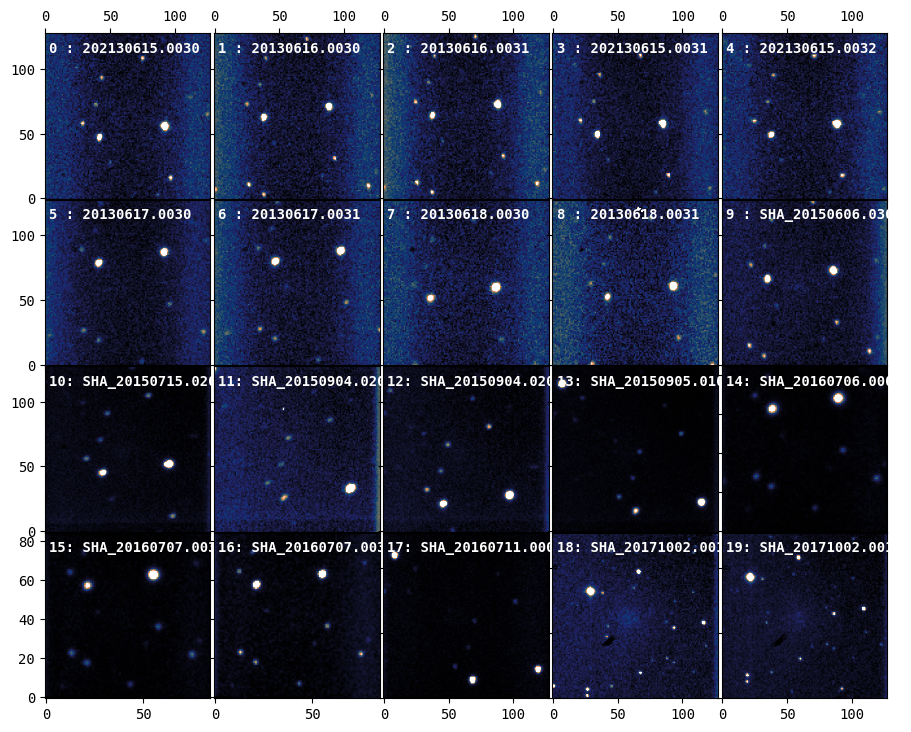

In [9]:
# Science images thumbnail grid 
fig, axes, _ = run_src.sort_by('date').thumbnails()
fig.set_size_inches(9, 7)
fig

In [11]:
# Match calibration frames
from pySHOC import MATCH_DARKS, MATCH_FLATS

# DEBIAS
# need to debias flats & science observations
obs = g['flat'].join(g['object']) 
gobs, gdark = obs.match(g['dark'], *MATCH_DARKS, keep_nulls=False, report=True)

# compute master darks
mbias = gdark.merge_combine(np.median)

# Notice that i have previously placed all the correct dark and flat 
# observation files in the one folder. This is actually not necessary. If 
# you already have a folder where you store all your calibration data, you can
# read all those files and select the correct ones with a few lines of code 
# similar to what was done above. 
# For example:
# darks = shocCampaign.load_dir('/media/Oceanus/UCT/Observing/data/darks')
#_ = run_src.match(darks, *MATCH_DARKS, keep_nulls=False, report=True)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


                                                                                                                              
⎪Matched Observations                                                                                                        ⎪
⎪exact: ('instrument', 'binning', 'readout.preAmpGain', 'readout.outAmp.mode', 'readout.frq')                                ⎪
⎪closest: ('readout.outAmp.emGain', 'timing.exp')                                                                            ⎪
⎪B = ∅                                                                                                                       ⎪
⎪                                                  ⎪f…⎪                  ⎪   readout    ⎪               timing               ⎪
⎪     filename     ⎪ tel ⎪     target     ⎪obstype ⎪A ⎪  n   ⎪  ishape   ⎪     mode     ⎪          t0           ⎪  duration  ⎪
⎪                                                                                                              

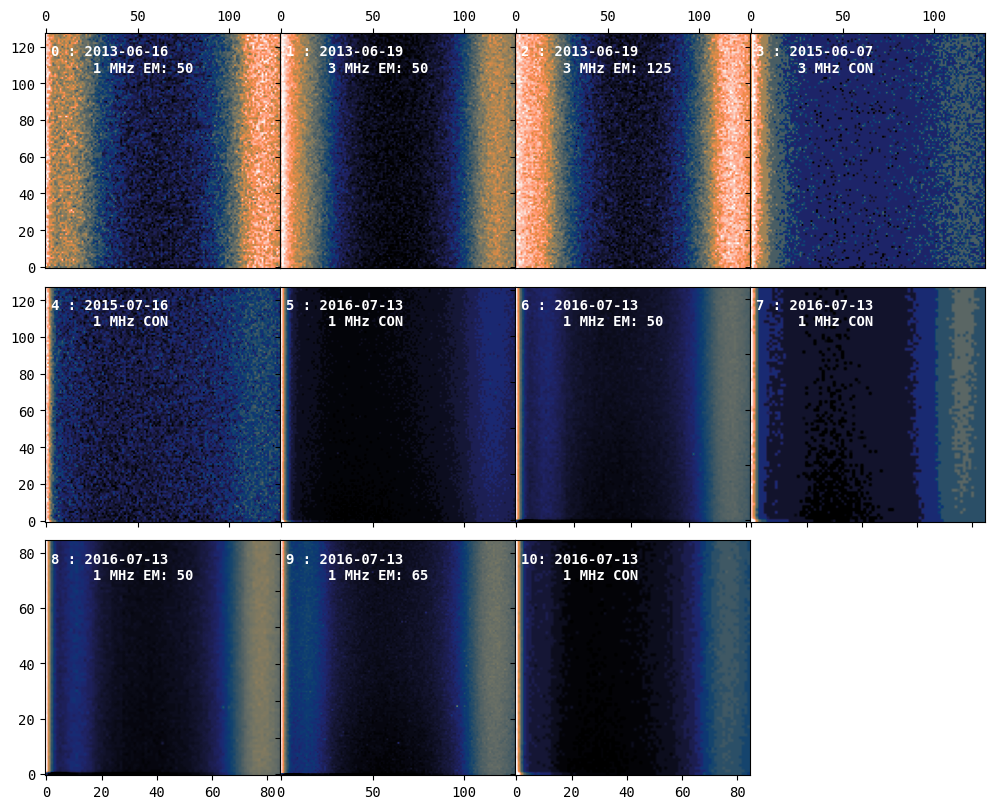

In [17]:
# display
fig, *_ = mbias.to_list().sort_by('date').thumbnails(title=('date', 'readout'))
fig

In [20]:
from obstools.stats import median_scaled_median

# Science files are large and won't all fit into RAM, so needs careful handling.
# use `set_calibrators` to do calibration arithmetic on the fly when accessing 
# data via `calibrated` attribute
gobj = gobs.select_by(obstype='object')
gobj.set_calibrators(mbias)

# Flat fields are small enough volume that we can safely read them into RAM.
gflat = gobs.select_by(obstype='flat')
gflat = gflat.subtract(mbias)

# Match calibrated flat fields to science observations. This grouping will be 
# different to that of `gflat` above since we are now matching for closest 
# dates
gobj, gflat = g['object'].match(gflat.to_list(), *MATCH_FLATS, keep_nulls=False,
                                report=True)

# flat field: median scale each image, then median combine images
mflat = gflat.merge_combine(median_scaled_median)
# 
gobj.set_calibrators(flats=mflat)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


                                                                                                                                     
⎪Matched Observations                                                                                                               ⎪
⎪exact: ('telescope', 'instrument', 'binning', 'filters')                                                                           ⎪
⎪closest: ('date',)                                                                                                                 ⎪
⎪None                                                                                                                               ⎪
⎪                                                               ⎪      readout       ⎪                    timing                    ⎪
⎪     filename     ⎪     target     ⎪obstype ⎪  n   ⎪  ishape   ⎪γₚᵣₑ ⎪     mode     ⎪          t0           ⎪  tExp   ⎪  duration  ⎪
⎪                                                             

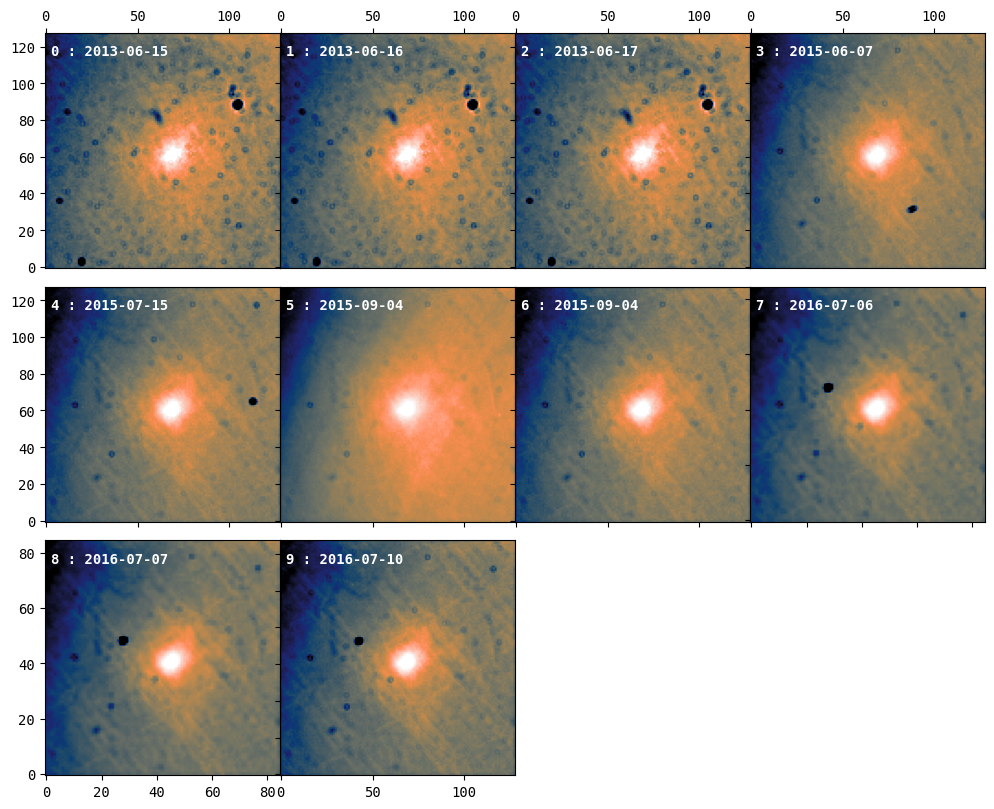

In [34]:
# display master flats
fig, *_ = mflat.to_list().sort_by('date').thumbnails(title='date')
fig

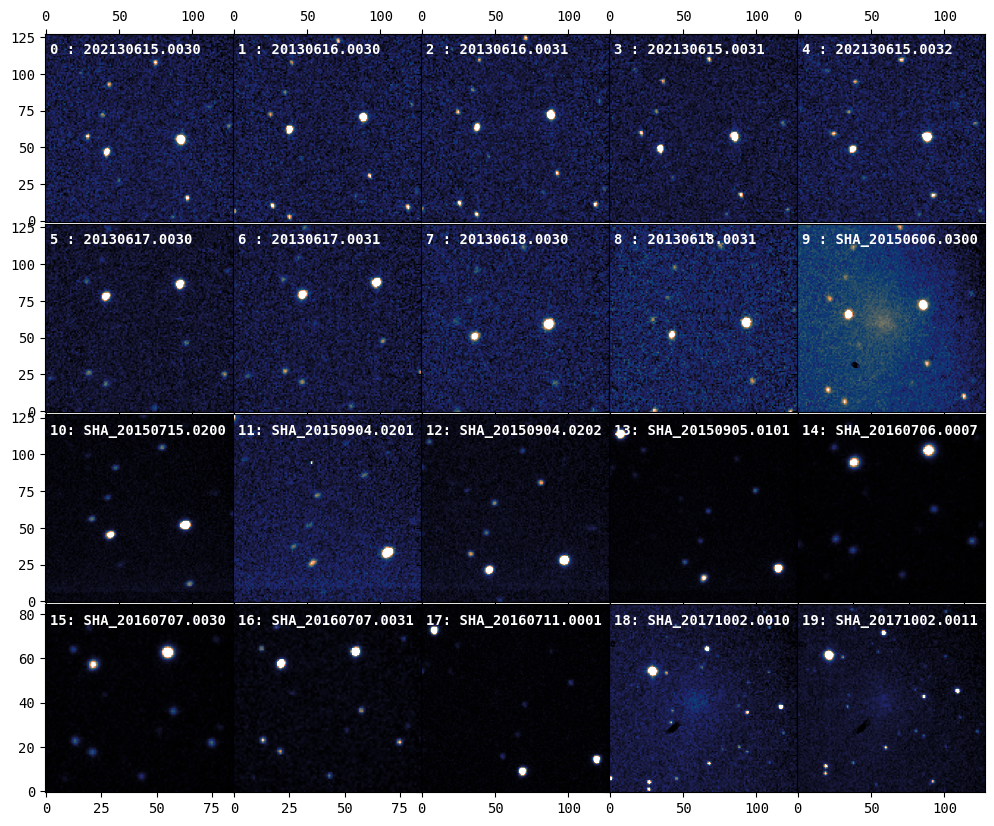

In [35]:
# show image grid (calibrated images)

# gobj.set_calibrators(mbias) # mflat
orun =  gobj.to_list().sort_by('date')
fig, *_ = orun.thumbnails(calibrated=True)
fig

In [36]:
# The flats for 20150606.0300.fits seem to introduce artifacts rather than 
# remove them.  This is most likely due to small number statistics since 
# there are only 30 frames in the flat field observation..
orun =  gobj.to_list().sort_by('date')
orun[9].calibrated.flat = None

# Also don't have calibration images for 1.0m data, which can't be helped

INFO:core.shocOldHDU:Computing median of 67 images (exposure depth of 10.0 seconds) for sample image from '202130615.0030.fits'
INFO:core.shocOldHDU:Computing median of 99 images (exposure depth of 10.0 seconds) for sample image from '20130616.0030.fits'
INFO:core.shocOldHDU:Computing median of 99 images (exposure depth of 10.0 seconds) for sample image from '20130616.0031.fits'
INFO:core.shocOldHDU:Computing median of 67 images (exposure depth of 10.0 seconds) for sample image from '202130615.0031.fits'
INFO:core.shocOldHDU:Computing median of 67 images (exposure depth of 10.0 seconds) for sample image from '202130615.0032.fits'
INFO:core.shocOldHDU:Computing median of 99 images (exposure depth of 10.0 seconds) for sample image from '20130617.0030.fits'
INFO:core.shocOldHDU:Computing median of 99 images (exposure depth of 10.0 seconds) for sample image from '20130617.0031.fits'
INFO:core.shocOldHDU:Computing median of 99 images (exposure depth of 10.0 seconds) for sample image from '2

INFO:registration.ImageRegister:Likelihood ratio: 1.00039
INFO:registration.ImageRegister:Accepting new parameters.


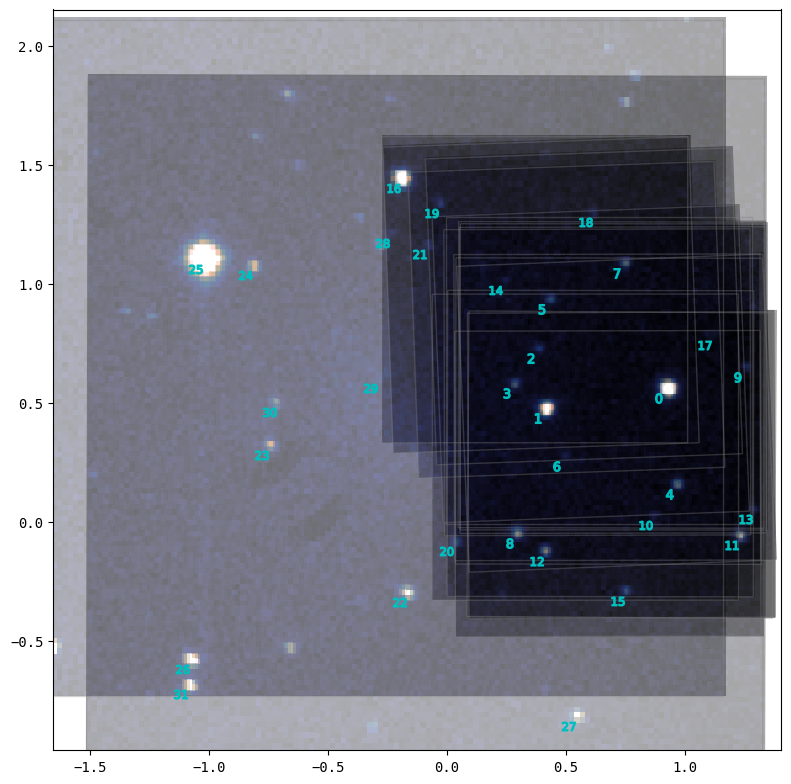

In [42]:
# Image registration & mosaic

# align images
reg = orun.coalign(plot=False) 

# plot
mp = reg.mosaic(alpha=0.35, cmap='cmr.dusk', number_sources=True)
mp.fig

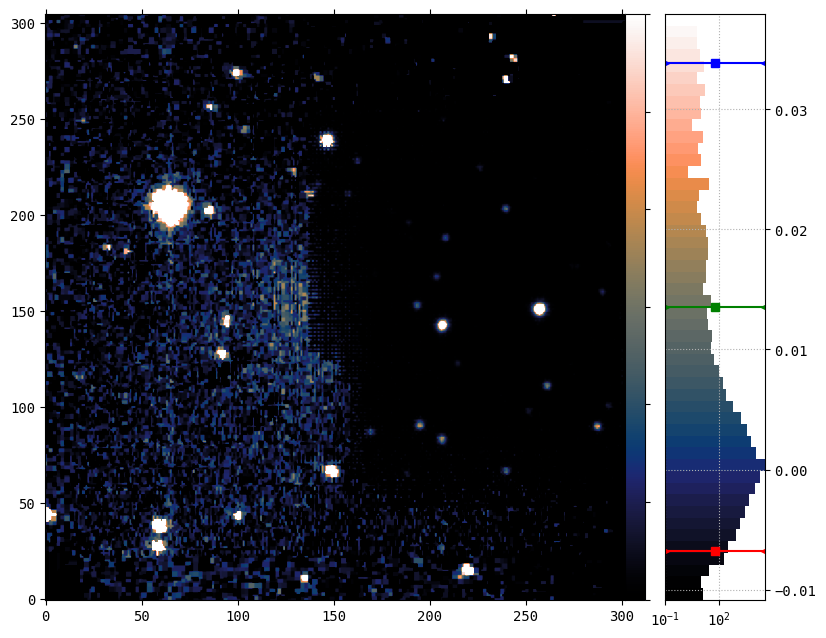

In [43]:
from scrawl.imagine import ImageDisplay

def pixel_transform(i: int):
    # scale images by source counts for source 0 and median subtract
    image = reg[i]
    a = image.data / image.counts[sidx[i] == 0]
    return a - np.ma.median(a)

# get source indices per frame
sidx = reg.source_indices
# get mean image across stack
g, bs = reg.binned_statistic(image_func=pixel_transform, interpolate=True)

im = ImageDisplay(bs.statistic.T)
im.imagePlot.set_clim(0, 0.012)
im.figure.set_size_inches(8, 8)
im.figure